In [56]:
import os
import zipfile
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.models import Model, load_model
from flask import Flask, request, render_template
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from PIL import Image
from PIL import Image, ImageDraw, ImageFont

In [40]:
# 1. Extracting and Processing the Dataset
extract_dir = 'project-cv'
zip_file_path = 'Bone_Fracture_Binary_Classification.zip'
extracted_folder = os.path.join(extract_dir, 'Bone_Fracture_Binary_Classification')

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

train_dir = os.path.join(extracted_folder, 'train')
fractured_train_dir = os.path.join(train_dir, 'fractured')
not_fractured_train_dir = os.path.join(train_dir, 'not fractured')

test_dir = os.path.join(extracted_folder, 'test')
fractured_test_dir = os.path.join(test_dir, 'fractured')
not_fractured_test_dir = os.path.join(test_dir, 'not fractured')

val_dir = os.path.join(extracted_folder, 'val')
fractured_val_dir = os.path.join(val_dir, 'fractured')
not_fractured_val_dir = os.path.join(val_dir, 'not fractured')

# Function to validate and remove corrupted images
def validate_images(dir_path):
    for subdir, _, files in os.walk(dir_path):
        for file in files:
            img_path = os.path.join(subdir, file)
            try:
                with Image.open(img_path) as img:
                    img.verify()  # Verify that it is, in fact, an image
                with Image.open(img_path) as img:
                    img.load()  # Ensure the image can be loaded
            except (IOError, SyntaxError) as e:
                print(f'Removing corrupted image: {img_path}')
                os.remove(img_path)

# Validate images in all directories
validate_images(train_dir)
validate_images(test_dir)
validate_images(val_dir)

Removing corrupted image: project-cv/Bone_Fracture_Binary_Classification/train/.DS_Store
Removing corrupted image: project-cv/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004143.jpg
Removing corrupted image: project-cv/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004347.jpg
Removing corrupted image: project-cv/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004134.jpg
Removing corrupted image: project-cv/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004308.jpg
Removing corrupted image: project-cv/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004148.jpg
Removing corrupted image: project-cv/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004149.jpg
Removing corrupted image: project-cv/Bone_Fracture_Binary_Classification/test/.DS_Store
Removing corrupted image: project-cv/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004143.jpg
Removing corrupted image: project-cv/Bone_Fracture_Binary_Classifica

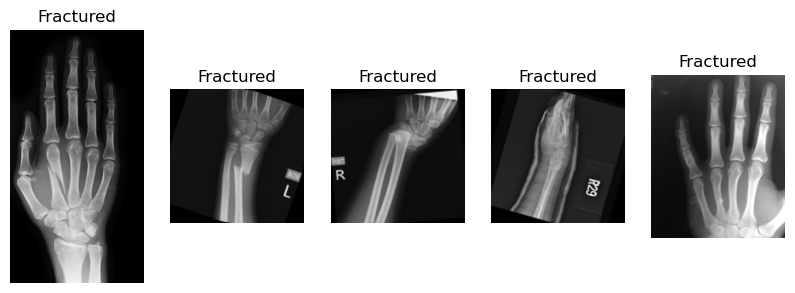

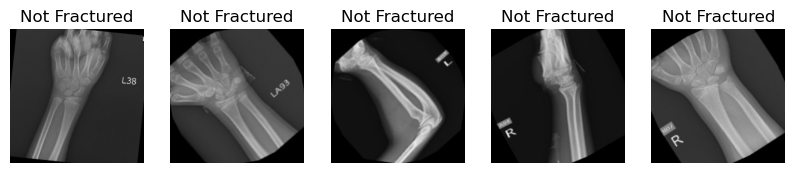

In [41]:
# 2. Exploratory Data Analysis (EDA)
def plot_sample_images(dir_path, label, n=5):
    sample_images = os.listdir(dir_path)[:n]
    plt.figure(figsize=(10, 10))
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(dir_path, img_name)
        img = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
    plt.show()

plot_sample_images(fractured_train_dir, 'Fractured')
plot_sample_images(not_fractured_train_dir, 'Not Fractured')

In [42]:
# 3. Preprocessing the Images
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='binary')
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(150, 150), batch_size=32, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=32, class_mode='binary')


Found 9240 images belonging to 2 classes.
Found 823 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [43]:
# 4. Selecting and Training a Machine Learning Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=val_generator,
    validation_steps=val_generator.samples // 32,
    epochs=10
)

model_file_path = 'bone_fracture_model.h5'
model.save(model_file_path)

Epoch 1/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6729 - loss: 0.5905

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


288/288 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - accuracy: 0.6732 - loss: 0.5903 - val_accuracy: 0.8575 - val_loss: 0.3732
Epoch 2/10
  1/288 ━━━━━━━━━━━━━━━━━━━━ 5:59 1s/step - accuracy: 0.7500 - loss: 0.5586

2024-06-13 20:51:46.892579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7500 - loss: 0.5586 - val_accuracy: 0.7826 - val_loss: 0.4072
Epoch 3/10


2024-06-13 20:51:47.859015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


288/288 ━━━━━━━━━━━━━━━━━━━━ 316s 1s/step - accuracy: 0.8174 - loss: 0.4184 - val_accuracy: 0.8750 - val_loss: 0.3223
Epoch 4/10
  1/288 ━━━━━━━━━━━━━━━━━━━━ 4:29 939ms/step - accuracy: 0.8438 - loss: 0.3748

2024-06-13 20:57:04.999538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8438 - loss: 0.3748 - val_accuracy: 0.9565 - val_loss: 0.2217
Epoch 5/10


2024-06-13 20:57:05.681663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


288/288 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - accuracy: 0.8547 - loss: 0.3602 - val_accuracy: 0.8662 - val_loss: 0.3028
Epoch 6/10
  1/288 ━━━━━━━━━━━━━━━━━━━━ 4:29 940ms/step - accuracy: 0.8750 - loss: 0.3651

2024-06-13 21:02:09.509282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8750 - loss: 0.3651 - val_accuracy: 0.8261 - val_loss: 0.2836
Epoch 7/10


2024-06-13 21:02:10.189119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


288/288 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - accuracy: 0.8696 - loss: 0.3249 - val_accuracy: 0.8425 - val_loss: 0.3271
Epoch 8/10
  1/288 ━━━━━━━━━━━━━━━━━━━━ 4:42 984ms/step - accuracy: 0.7812 - loss: 0.3605

2024-06-13 21:07:14.656993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7812 - loss: 0.3605 - val_accuracy: 0.8696 - val_loss: 0.3671
Epoch 9/10


2024-06-13 21:07:15.347801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


288/288 ━━━━━━━━━━━━━━━━━━━━ 359s 1s/step - accuracy: 0.8841 - loss: 0.2988 - val_accuracy: 0.9162 - val_loss: 0.2389
Epoch 10/10
  1/288 ━━━━━━━━━━━━━━━━━━━━ 4:37 968ms/step - accuracy: 0.9062 - loss: 0.2516

2024-06-13 21:13:15.159424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9062 - loss: 0.2516 - val_accuracy: 0.8696 - val_loss: 0.2540


2024-06-13 21:13:15.852441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [44]:
# 5. Evaluating the Model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.4f}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 949ms/step - accuracy: 0.8766 - loss: 0.2906
Test Accuracy: 0.8660


In [45]:
# 6. Making Predictions on the Test Set
predictions = model.predict(test_generator)
y_true = test_generator.classes
y_pred = predictions > 0.5

16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step


16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step


/var/folders/j8/4l5sfc6x0fsfnmp1684bsxw40000gn/T/ipykernel_7233/3352236833.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f'True: {class_labels[true_labels[i]]}\nPred: {class_labels[int(predicted_labels[i])]}')


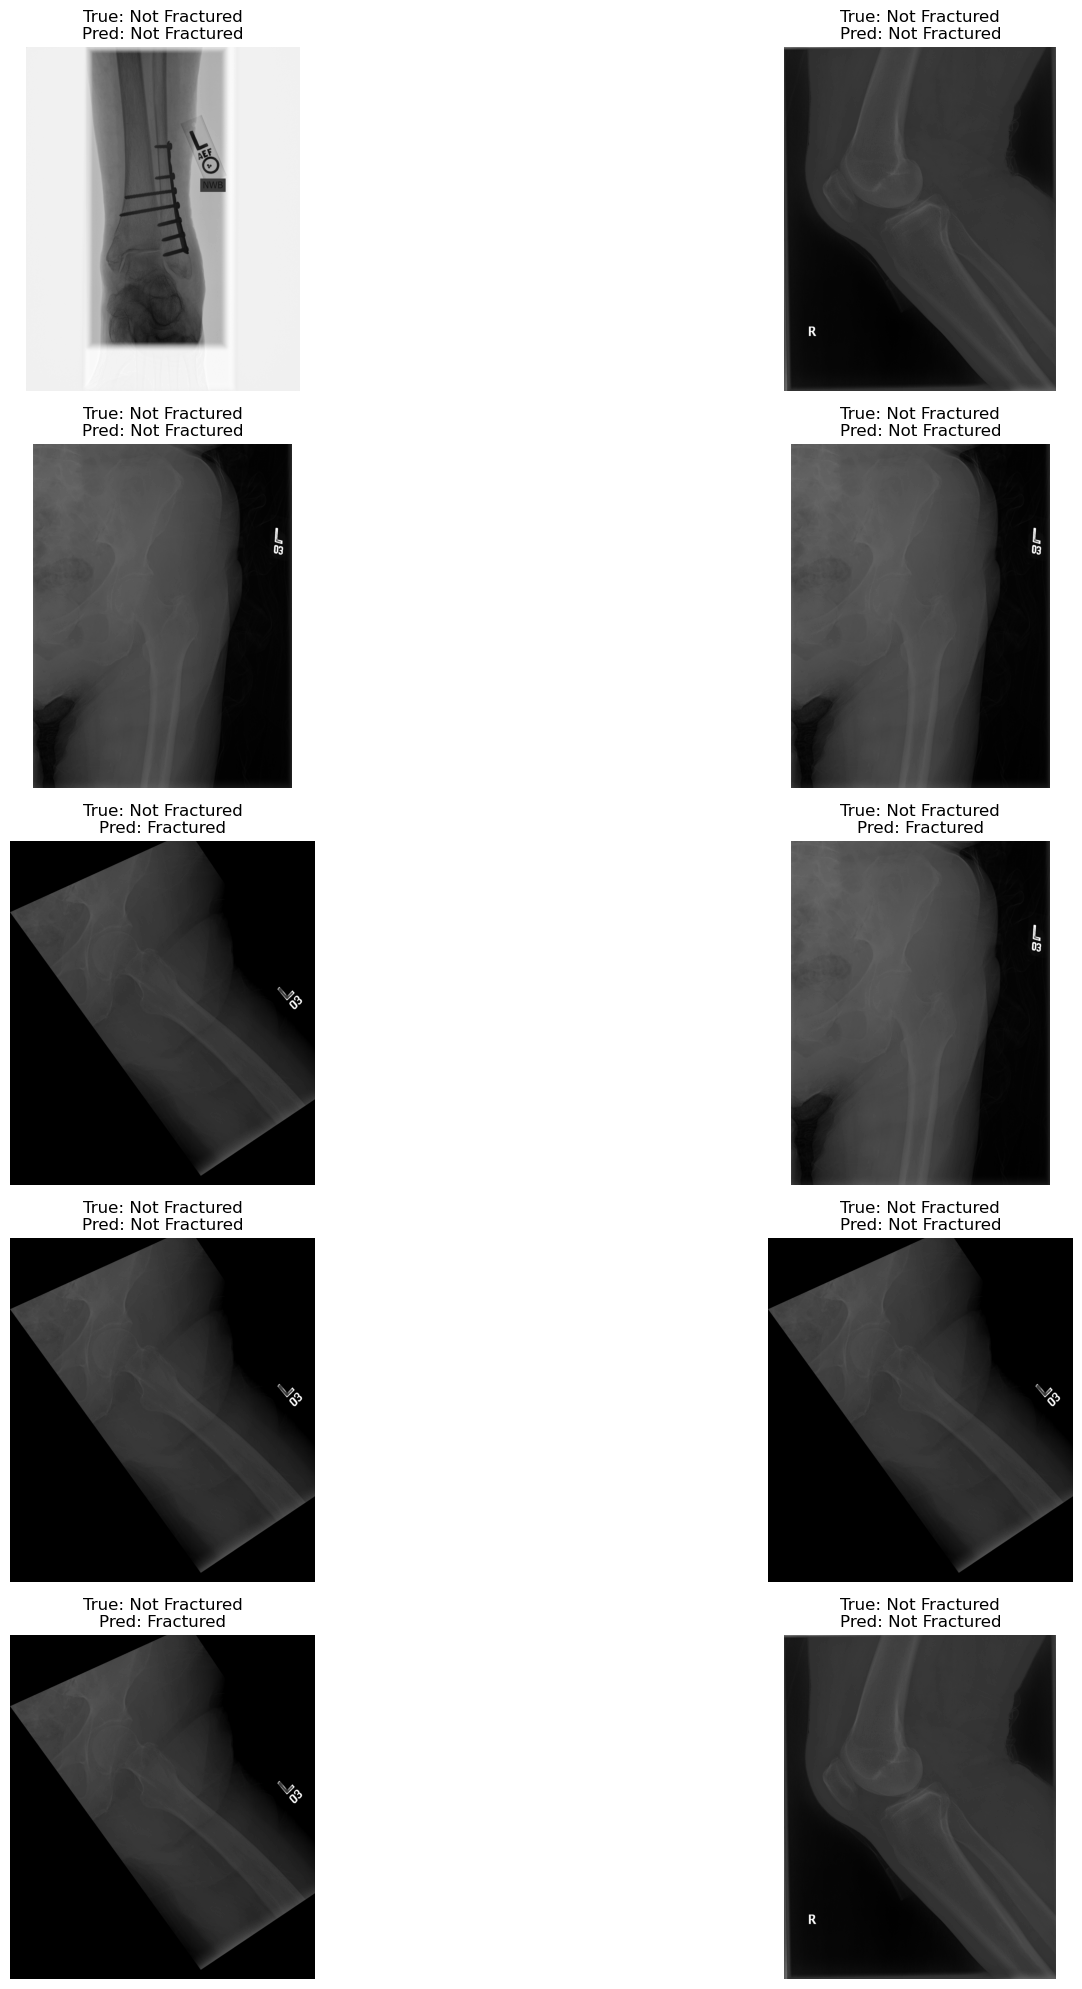

In [54]:
# Making predictions on the test set
predictions = model.predict(test_generator)
y_true = test_generator.classes
y_pred = predictions > 0.5

# Getting the file paths of the images in the test set
test_image_paths = []
for i in range(len(test_generator.filenames)):
    test_image_paths.append(os.path.join(test_dir, test_generator.filenames[i]))

# Function to plot images with predicted labels
def plot_images_with_predictions(image_paths, true_labels, predicted_labels, class_labels, n=10):
    plt.figure(figsize=(20, 20))
    for i in range(n):
        img = Image.open(image_paths[i])
        plt.subplot(5, 2, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'True: {class_labels[true_labels[i]]}\nPred: {class_labels[int(predicted_labels[i])]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Class labels
class_labels = ['Not Fractured', 'Fractured']

# Plot the first 10 test images with their true and predicted labels
plot_images_with_predictions(test_image_paths, y_true, y_pred, class_labels, n=10)


In [57]:
# Create a directory to save the images
output_dir = 'predicted_images'
os.makedirs(output_dir, exist_ok=True)

# Class labels
class_labels = ['Not Fractured', 'Fractured']

# Function to save images with predicted labels
def save_images_with_predictions(image_paths, true_labels, predicted_labels, class_labels, output_dir, n=10):
    for i in range(n):
        img = Image.open(image_paths[i])
        draw = ImageDraw.Draw(img)
        font = ImageFont.load_default()

        # Annotate the image with true and predicted labels
        true_label = class_labels[true_labels[i]]
        pred_label = class_labels[int(predicted_labels[i])]
        text = f'True: {true_label}, Pred: {pred_label}'
        draw.text((10, 10), text, fill='white', font=font)

        # Save the image with a filename indicating the prediction
        img_name = os.path.basename(image_paths[i])
        img_save_path = os.path.join(output_dir, f'{i+1}_{true_label}_pred_{pred_label}_{img_name}')
        img.save(img_save_path)

# Save the first 10 test images with their true and predicted labels
save_images_with_predictions(test_image_paths, y_true, y_pred, class_labels, output_dir, n=10)

/var/folders/j8/4l5sfc6x0fsfnmp1684bsxw40000gn/T/ipykernel_7233/1886189108.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_label = class_labels[int(predicted_labels[i])]


In [47]:
# 7. Calculating Additional Metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Precision: 0.5104
Recall: 0.4695
F1-score: 0.4891


In [52]:
# 8. Deployment using Flask
app = Flask(__name__)

model = load_model('bone_fracture_model.h5')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Fix: Compile the model before using it

@app.route('/', methods=['GET', 'POST'])
def home():
    if request.method == 'POST':
        image_file = request.files['image']
        image = Image.open(image_file)
        image = image.resize((150, 150))
        image_array = np.array(image) / 255.0
        image_array = np.expand_dims(image_array, axis=0)
        
        prediction = model.predict(image_array)
        class_name = 'Fractured' if prediction > 0.5 else 'Not Fractured'
        
        return render_template('result.html', class_name=class_name)
    
    return render_template('index.html')

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with watchdog (fsevents)
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 15, in <module>
    from ipykernel import kernelapp as app
  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel/__init__.py", line 7, in <module>
    from .connect import *
  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel/connect.py", line 12, in <module>
    import jupyter_client
  File "/opt/anaconda3/lib/python3.11/site-packages/jupyter_client/__init__.py", line 8, in <module>
    from .asynchronous import AsyncKernelClient  # noqa
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/jupyter_client/asynchronous/__init__.py", line 1, in <module>
    

SystemExit: 1

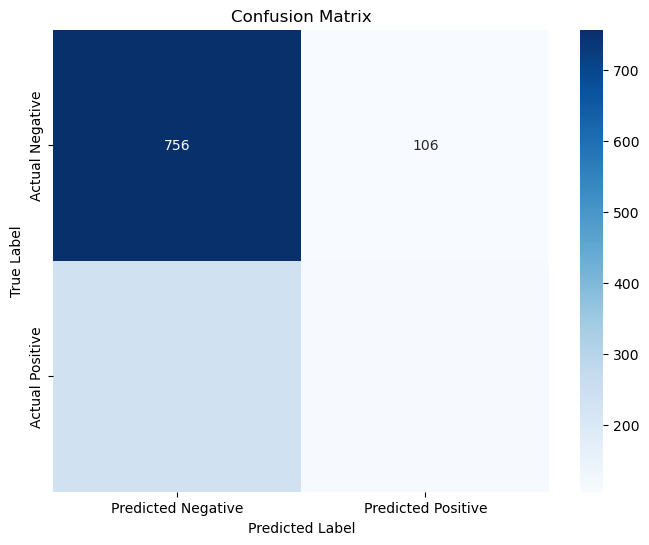

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming these are the values for your confusion matrix
TP = 110
TN = 756
FP = 106
FN = 234

# Creating the confusion matrix array
conf_matrix = np.array([[TN, FP], [FN, TP]])

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Save the plot as an image
plt.savefig('confusion_matrix.png')
plt.show()
